# I'm Something of a Painter Myself

In [1]:
import numpy as np # linear algebra
import pandas as pd

In [39]:
import os
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import random
from tensorflow.keras import layers
import time

In [3]:
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c gan-getting-started

 96% 353M/367M [00:02<00:00, 178MB/s]
100% 367M/367M [00:02<00:00, 185MB/s]


In [ ]:
!unzip  gan-getting-started.zip

## Introduction

For this project, we will be using Generative Adversarial Network (GANs) to imitate art work of the artist, Claude Monet. We will recreate the style by generating photos from scratch.

The monet directories contain Monet Painting which will be used to train the GAN model. We will apply the Monet-style to the photos provided and regenerate the photos using the GAN model.

- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format

There are 7,038 images in photo_jpg that we have to convert to monet-style. The image size is (256,256,3)

In [14]:
folder_path = "photo_jpg"

# List all jpg files in the folder
jpg_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]

# Count the number of jpg files
num_jpg_files = len(jpg_files)
print(f"Number of JPG files: {num_jpg_files}")

# Get the shape of one image (if there are any jpg files)
if num_jpg_files > 0:
    sample_image_path = os.path.join(folder_path, jpg_files[0])
    image = cv2.imread(sample_image_path)

    if image is not None:
        print(f"Shape of {jpg_files[0]}: {image.shape}")  # (height, width, channels)
    else:
        print("Error reading the image.")


Number of JPG files: 7038
Shape of 8fc153c94e.jpg: (256, 256, 3)


There are 7,038 images in monet_jpg which are monet-style which we can use to train our model. The image size is (256,256,3)

In [15]:
folder_path = "monet_jpg"

# List all jpg files in the folder
jpg_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]

# Count the number of jpg files
num_jpg_files = len(jpg_files)
print(f"Number of JPG files: {num_jpg_files}")

# Get the shape of one image (if there are any jpg files)
if num_jpg_files > 0:
    sample_image_path = os.path.join(folder_path, jpg_files[0])
    image = cv2.imread(sample_image_path)

    if image is not None:
        print(f"Shape of {jpg_files[0]}: {image.shape}")  # (height, width, channels)
    else:
        print("Error reading the image.")


Number of JPG files: 300
Shape of 2acfbab228.jpg: (256, 256, 3)


## Exploratory Data Analysis

Let's display sample of regular and Monet-style images to see what we will be working with. As we can see from the sample below, the Monet-style images look painted with a brush.

Photo JPG Samples:


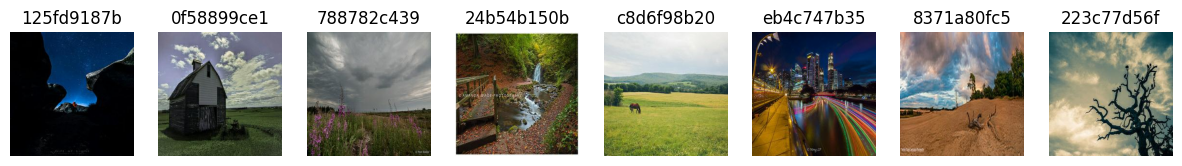

Monet JPG Samples:


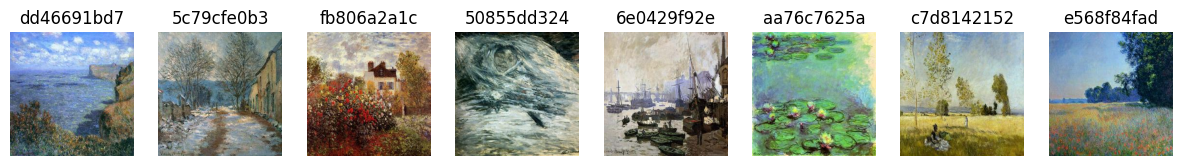

In [17]:
def load_and_display_images(folder, num_samples=8):
    image_files = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]

    num_samples = min(num_samples, len(image_files))
    sampled_images = random.sample(image_files, num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(img_name[:10])

    plt.show()

print("Photo JPG Samples:")
load_and_display_images("photo_jpg")

print("Monet JPG Samples:")
load_and_display_images("monet_jpg")


Next, we will load the image dataset into a training dataset so we can use it to train our model with. We will be using the features of the Tensorflow library to help us load the data.

In [29]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [30]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [31]:
MONET_FILENAMES = tf.io.gfile.glob(str('/monet_tfrec/*.tfrec'))

PHOTO_FILENAMES = tf.io.gfile.glob(str('/photo_tfrec/*.tfrec'))

In [32]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

## Model Building

We will build a GAN model using the following architecture:
1. Generator
- 100-dimensional noise vector as input
- Conv2DTranspose
- batch normalization, and
- activations.
- upsampling step
- final output of 256x256x3 (RGB image)

2. Discriminator
- 256x256x3 image as input (real or generated).
- convolutional layers with increasing depth (64 → 128 → 256 → 512 filters).
- LeakyReLU activations and
- batch normalization
- output layer

3. Adversarial Model
- Combines the Generator and Discriminator into one network.
- Trains the Generator

Build Generator

In [81]:
def build_generator(image_size=256, input_size=100):

    #Build an input layer
    gen_input = keras.Input(shape=(input_size,))

    x = layers.Dense(16 * 16 * 512)(gen_input)
    x = layers.Reshape((16, 16, 512))(x)

    #Use ConvTranspose
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(128, kernel_size=[5,5], strides=2, padding='same')(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(3, kernel_size=[5,5], strides=2, padding='same')(x)

    x = layers.UpSampling2D(size=(2, 2))(x)  # Upsample to 32x32
    #Output layer for Generator
    x = layers.Activation('tanh')(x)

    #Build model using Model API
    generator = keras.Model(gen_input, x, name='generator')

    return generator

Build Discriminator

In [82]:
def build_discriminator(data_shape=(256, 256, 3)):

    dis_input = keras.Input(shape=data_shape)

    # First convolutional layer (128x128)
    x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(dis_input)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Second convolutional layer
    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Third convolutional layer
    x = layers.Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Fourth convolutional layer
    x = layers.Conv2D(512, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Fifth convolutional layer
    x = layers.Conv2D(512, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)


    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    discriminator = keras.Model(dis_input, x, name='discriminator')

    return discriminator


Build the Model

In [83]:
def build_models():
    noise_size = 100
    lr = 2e-4
    decay = 6e-8


    base_discriminator = build_discriminator(data_shape=(256, 256, 3))


    discriminator = keras.Model(inputs=base_discriminator.inputs,
                                outputs=base_discriminator.outputs)
    optimizer_d = keras.optimizers.Adam(learning_rate=lr, decay=decay)

    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer_d,
                          metrics=['accuracy'])


    generator = build_generator(image_size=256, input_size=noise_size)

    frozen_discriminator = keras.Model(inputs=base_discriminator.inputs,
                                       outputs=base_discriminator.outputs)

    frozen_discriminator.trainable = False

    optimizer_g = keras.optimizers.Adam(learning_rate=0.001)

    adversarial = keras.Model(generator.input,
                              frozen_discriminator(generator.output))

    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer_g,
                        metrics=['accuracy'])

    return generator, discriminator, adversarial


In [94]:
def generate_images(generator, dataset, output_dir, num_images=7000):
    os.makedirs(output_dir, exist_ok=True)

    for i, image in enumerate(dataset.take(num_images)):
        generated_image = generator.predict(image)
        generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)  # Convert back to [0, 255]

        output_path = os.path.join(output_dir, f"generated_{i}.jpg")
        tf.keras.preprocessing.image.save_img(output_path, generated_image[0])

    print(f"Generated images saved in {output_dir}")

# Generate Monet-style images from photos
generator_monet = build_generator()
generate_images(generator_monet, photo_ds, "generated_monet")

Generated images saved in generated_monet


Overview of Model Structure

In [85]:
G, D, A = build_models()
G.summary()
D.summary()
A.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 131072)              │      13,238,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_24                  │ (None, 32, 32, 128)         │       1,638,528 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_25                  │ (None, 64, 64, 64)          │         204,864 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_26                  │ (None, 128, 128, 3)         │           4,803 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 256, 256, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,089,283 (57.56 MB)

 Trainable params: 15,087,875 (57.56 MB)

 Non-trainable params: 1,408 (5.50 KB)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 128, 128, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_44 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 64, 64, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_45 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 32, 32, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_46 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 16, 16, 512)         │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_47 (LeakyReLU)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 8, 8, 512)           │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_48 (LeakyReLU)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,899,073 (41.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,899,073 (41.58 MB)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 131072)              │      13,238,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_24                  │ (None, 32, 32, 128)         │       1,638,528 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_25                  │ (None, 64, 64, 64)          │         204,864 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_26                  │ (None, 128, 128, 3)         │           4,803 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_18 (Functional)           │ (None, 1)                   │      10,899,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,988,356 (99.14 MB)

 Trainable params: 15,087,875 (57.56 MB)

 Non-trainable params: 10,900,481 (41.58 MB)

## Results and Analysis

After building and training the GAN model, we were able to generate 7000 monet style images. It seems pretty accurate however once Kaggle processes the images I will report the test score here.

In [98]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample(generator, dataset):
    """Displays a single generated image."""
    for img in dataset.take(1):  # Take one image from dataset
        generated_img = generator(img, training=False)[0].numpy()  # Generate Monet-style image
        generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)  # Rescale from [-1, 1] to [0, 255]

        plt.figure(figsize=(6, 6))
        plt.imshow(generated_img)
        plt.axis("off")
        plt.show()
        break  # Stop after one image

show_sample(generator_monet, photo_ds)


## Conclusion

We built a GAN model to generate Monet-Style photos. Next time, I would like to experiment with the model architecture by adding more convolutional layers and regularization such as drop out and batch normalization layer to improve the accuracy.

## References

- "GAN: Getting Started." Kaggle, www.kaggle.com/competitions/gan-getting-started/overview. Accessed 4 Mar. 2025.

- Shivansh002. "Gentle Introduction to GAN." Kaggle, www.kaggle.com/code/shivansh002/gentle-introduction-to-gan. Accessed 4 Mar. 2025.